References:
- [elastropy's playlist on Physics Informed Neural Networks](https://youtube.com/playlist?list=PLM7DTyYjZGuLmg3f6j40fEF18jyQmYsC2&si=35a-jywar0nasELh)


This notebook continues from the previous 2 notebooks on basic PINNs:
- [basic-pinn-1](https://www.kaggle.com/code/aryamanbansal/basic-pinn-1/edit)
- [basic-pinn-2](https://www.kaggle.com/code/aryamanbansal/basic-pinn-2/edit)
- [basic-pinn-3](https://www.kaggle.com/code/aryamanbansal/basic-pinn-3/edit)

# Physics Informed Neural Networks (PINNs)

## Problem Definition - Solving a System of ODEs

Consider the following system of ordinary differential equations (ODEs):

$$
\begin{equation}
\frac{dx}{dt} + 2x + y = 0 \tag{1}
\end{equation}
$$

$$
\begin{equation}
\frac{dy}{dt} + x + 2y = 0 \tag{2}
\end{equation}
$$

The initial conditions are given by:

$$x(0) = 1, \quad y(0) = 0$$

We will use a Physics Informed Neural Network (PINN) to solve for x(t) and y(t) over the domain of time $t \in [0, 5]$.

The analytical solution to this system of ODEs is:

$$
\begin{equation}
x(t) = \frac{1}{2}\left( e^{-t} + e^{-3t} \right) \tag{3}
\end{equation}
$$ 

$$
\begin{equation}
y(t) = \frac{1}{2}\left( -e^{-t} + e^{-3t} \right) \tag{4}
\end{equation}
$$

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

# plot settings
plt.close("all")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 100

print("imports done!")

imports done!


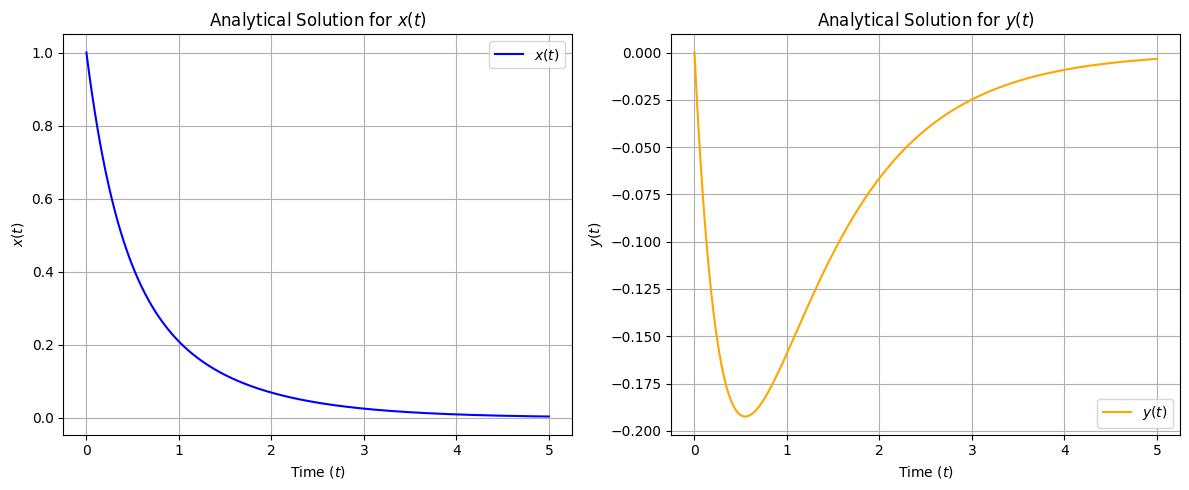

In [20]:
# Define the time domain
t = np.linspace(0, 5, 500)

# Analytical solution
x_analytical = 0.5 * (np.exp(-t) + np.exp(-3*t))   # eqn 3
y_analytical = 0.5 * (-np.exp(-t) + np.exp(-3*t))  # eqn 4


# Plotting the analytical solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(t, x_analytical, label=r"$x(t)$", color="blue")
axs[0].set_title(r"Analytical Solution for $x(t)$")
axs[0].set_xlabel(r"Time ($t$)")
axs[0].set_ylabel(r"$x(t)$")
axs[0].grid()
axs[0].legend()
axs[1].plot(t, y_analytical, label=r"$y(t)$", color="orange")
axs[1].set_title(r"Analytical Solution for $y(t)$")
axs[1].set_xlabel(r"Time ($t$)")
axs[1].set_ylabel(r"$y(t)$")
axs[1].grid()
axs[1].legend()
plt.tight_layout()
plt.show()

## Loss functions

There are 3 main components to the loss function in a PINN:

#### 1. Data Loss
This term measures the difference between the predicted solution and the true solution at given data points. For example, if we have a set of data points $(t_i, x_i)$ and $(t_i, y_i)$, the data loss can be defined as:
$$\text{Data Loss of x} = \mathcal{L}_{{data}_x} = \frac{1}{N} \sum_{i=1}^{N} (\hat{x}(t_i) - x_i)^2$$

$$\text{Data Loss of y} = \mathcal{L}_{{data}_y} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}(t_i) - y_i)^2$$

where $N$ is the number of data points.

#### 2. ODE Loss
This term measures how well the neural network satisfies the differential equation. It is computed by evaluating the neural network at a set of collocation points and calculating the residual of the ODE. We need to minimize the following equations:

\begin{align*}
f_1: \quad & \frac{d\hat{x}}{dt} + 2\hat{x} + \hat{y} = 0 \\
f_2: \quad & \frac{d\hat{y}}{dt} + \hat{x} + 2\hat{y} = 0
\end{align*}

For our example, the ODE loss can be defined as:

\begin{align*}
\text{ODE Loss 1} = \mathcal{L}_{{ODE}_1} &= \frac{1}{M} \sum_{i=1}^{M} \left( \frac{d\hat{x}}{dt}(t_i) + 2\hat{x}(t_i) + \hat{y}(t_i) \right)^2 \\ \\
\text{ODE Loss 2} = \mathcal{L}_{{ODE}_2} &= \frac{1}{M} \sum_{i=1}^{M} \left( \frac{d\hat{y}}{dt}(t_i) + \hat{x}(t_i) + 2\hat{y}(t_i) \right)^2
\end{align*}

#### 3. Initial condition Loss
This term ensures that the neural network satisfies the initial condition. For our example, the initial condition loss can be defined as:

\begin{align*}
\text{Initial Condition Loss of x} = \mathcal{L}_{{initial}_x} &= \left(x(0) - \hat{x}(0)\right)^2 \\
&= \left(1 - \hat{x}(0)\right)^2 \\
\end{align*}

\begin{align*}
\text{Initial Condition Loss of y} = \mathcal{L}_{{initial}_y} &= \left(y(0) - \hat{y}(0)\right)^2 \\
&= \left(0 - \hat{y}(0)\right)^2 \\
&= \hat{y}(0)^2 \\
\end{align*}

#### 4. Total Loss
The total loss function is a weighted sum of the 6 terms defined above:

$$\mathcal{L}_{total} = \lambda_1 \cdot \mathcal{L}_{{data}_x} + \lambda_2 \cdot \mathcal{L}_{{data}_y} + \lambda_3 \cdot \mathcal{L}_{{ODE}_1} + \lambda_4 \cdot \mathcal{L}_{{ODE}_2} + \lambda_5 \cdot \mathcal{L}_{{initial}_x} + \lambda_6 \cdot \mathcal{L}_{{initial}_y}$$

where $\lambda_1$, $\lambda_2$, $\lambda_3$, $\lambda_4$, $\lambda_5$, and $\lambda_6$ are hyperparameters that control the relative importance of each term.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
# This PINN will output 2 values:
# one is a predicted value of x(t) and the other is a predicted value of y(t).
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_dim),
        )
    
    def forward(self, t):
        return self.model(t)


print("physics-informed neural network created!")

physics-informed neural network created!


In [23]:
# Automatic differentiation
def derivative(T, t):
    """
    Computes dT/dt using PyTorch's autograd.
    T and t must be tensors with requires_grad=True for t.
    """
    return torch.autograd.grad(
        T, t,
        grad_outputs=torch.ones_like(T),
        create_graph=True
    )[0]


print("automatic differentiation function created!")

automatic differentiation function created!


In [24]:
def loss_function(model, t, x, y, lambda_data_x, lambda_data_y, lambda_ode_1, lambda_ode_2, lambda_ic_x, lambda_ic_y):
    # make a fresh copy of t that requires grads
    # we must do this before passing x through the model
    # otherwise the forward-graph will already be built
    t_coll = t.clone().detach().requires_grad_(True)
    
    # Data loss
    output = model(t)
    x_pred, y_pred = output[:, 0], output[:, 1]
    residual_data_x = x_pred - x
    residual_data_y = y_pred - y
    data_loss_x = torch.mean(residual_data_x.pow(2))
    data_loss_y = torch.mean(residual_data_y.pow(2))

    # ODE loss
    output_coll = model(t_coll)
    x_coll, y_coll = output_coll[:, 0], output_coll[:, 1]
    x_t = derivative(x_coll, t_coll)   # dx/dt
    y_t = derivative(y_coll, t_coll)   # dy/dt
    residual_ode_1 = x_t + 2*x_coll + y_coll
    ode_loss_1 = torch.mean(residual_ode_1.pow(2))
    residual_ode_2 = y_t + x_coll + 2*y_coll
    ode_loss_2 = torch.mean(residual_ode_2.pow(2))

    # Initial condition loss
    output_ic = model(torch.tensor([[0.0]], device=device))
    x_0, y_0 = output_ic[:, 0], output_ic[:, 1]
    ic_x = (1 - x_0).pow(2)
    ic_y = y_0.pow(2)
    
    # Total loss
    data_loss = lambda_data_x * data_loss_x  +  lambda_data_y * data_loss_y
    ode_loss = lambda_ode_1 * ode_loss_1  +  lambda_ode_2 * ode_loss_2
    initial_loss = lambda_ic_x * ic_x  +  lambda_ic_y * ic_y
    total_loss = data_loss + ode_loss + initial_loss
    return total_loss


print("loss function created!")

loss function created!


In [25]:
def train(model, t_data, x_data, y_data, lambda_data_x, lambda_data_y, lambda_ode_1, lambda_ode_2, lambda_ic_x, lambda_ic_y, 
          epochs=10000, learning_rate=0.001, device="cpu"):
    model = model.to(device)
    t_data = t_data.to(device)
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        loss = loss_function(model, t_data, x_data, y_data, lambda_data_x, lambda_data_y, lambda_ode_1, 
                             lambda_ode_2, lambda_ic_x, lambda_ic_y)
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model


print("training function created!")

training function created!


In [26]:
# Generate training data
def generate_data(num_points=1000, device="cpu"):
    # generate evenly spaced points from the domain [t_min, t_max]
    t_data = torch.linspace(0, 5, num_points).view(-1, 1)    # collocation points
    t_data = t_data.to(device)
    x_data = 0.5 * (torch.exp(-t_data) + torch.exp(-3*t_data))  # eqn 3
    x_data = x_data.to(device)
    y_data = 0.5 * (-torch.exp(-t_data) + torch.exp(-3*t_data))  # eqn 4
    y_data = y_data.to(device)
    return t_data, x_data, y_data


print("data generation functions created!")

data generation functions created!


In [27]:
# Hyperparameters
input_dim = 1
output_dim = 2
hidden_units = 64
epochs = 4000
learning_rate = 0.001
lambda_data_x = 0.0
lambda_data_y = 0.0
lambda_ode_1 = 1.0
lambda_ode_2 = 1.0
lambda_ic_x = 1.0
lambda_ic_y = 1.0
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate training data and collocation points
t_data, x_data, y_data = generate_data(100, device)

# Initialize the PINN model
model = PINN(input_dim, hidden_units, output_dim)

# Train the model
trained_model = train(model, t_data, x_data, y_data, lambda_data_x, lambda_data_y, 
                      lambda_ode_1, lambda_ode_2, lambda_ic_x, lambda_ic_y, epochs, 
                      learning_rate, device)


  1%|          | 37/4000 [00:00<00:20, 193.34it/s]

Epoch 0, Loss: 2.085447072982788


 26%|██▌       | 1029/4000 [00:04<00:12, 236.00it/s]

Epoch 1000, Loss: 0.22044014930725098


 51%|█████     | 2032/4000 [00:08<00:08, 220.90it/s]

Epoch 2000, Loss: 0.21925072371959686


 76%|███████▌  | 3029/4000 [00:13<00:04, 229.67it/s]

Epoch 3000, Loss: 0.2183794528245926


100%|██████████| 4000/4000 [00:17<00:00, 226.00it/s]


In [31]:
gc.collect()
print("freed up some memory")

freed up some memory


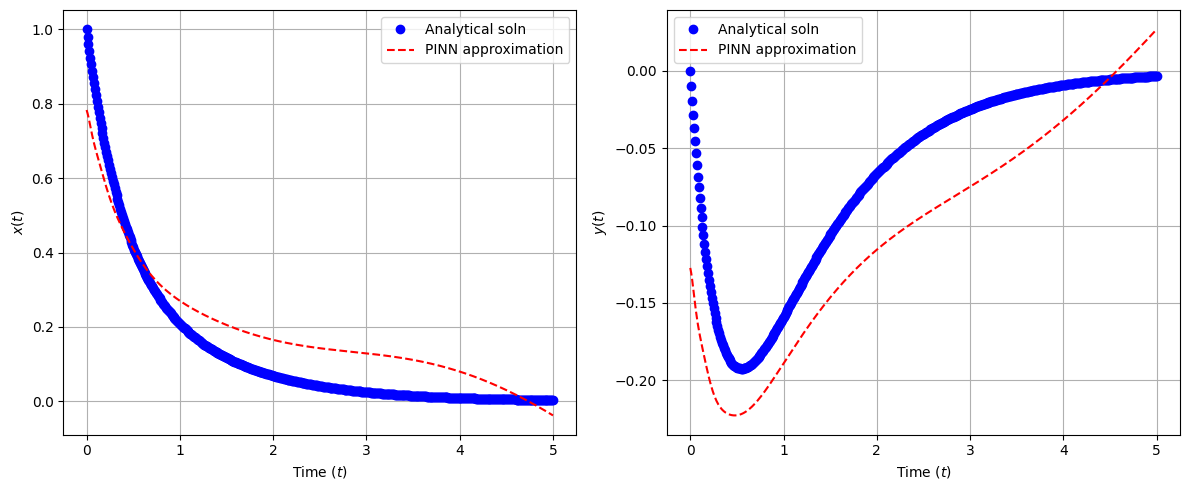

In [36]:
# Plot the results
t_data, x_data, y_data = generate_data(500, device)
x_data = x_data.cpu().detach().numpy()
y_data = y_data.cpu().detach().numpy()
output = trained_model(t_data)
x_pred, y_pred = output[:, 0], output[:, 1]
x_pred = x_pred.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
t_data = t_data.cpu().detach().numpy()

# Plotting the analytical solution
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(t_data, x_data, 'o', label="Analytical soln", color="blue")
axs[0].plot(t_data, x_pred, '--', label="PINN approximation", color="red")
axs[0].set_xlabel(r"Time ($t$)")
axs[0].set_ylabel(r"$x(t)$")
axs[0].grid()
axs[0].legend()
axs[1].plot(t_data, y_data, 'o', label="Analytical soln", color="blue")
axs[1].plot(t_data, y_pred, '--', label="PINN approximation", color="red")
axs[1].set_xlabel(r"Time ($t$)")
axs[1].set_ylabel(r"$y(t)$")
axs[1].grid()
axs[1].legend()
plt.tight_layout()
plt.show()